In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
def SelectModel(pathfile,modelname):
    df = pd.read_csv(pathfile)
    return df[df['model_name'].isin([modelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name'],axis=1)

In [ ]:
##clear null prices

In [17]:
SelectModel('/home/gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf')

,transmission,color,odometer_value,year_produced,engine_fuel,engine_capacity,state,drivetrain,price_usd
0,mechanical,black,213000,2001,gasoline,1.8,owned,front,6300.00
1,mechanical,red,260000,1999,diesel,1.9,owned,front,3400.00
2,mechanical,blue,280000,1996,diesel,1.9,owned,front,2100.00
3,mechanical,blue,290000,1994,gasoline,1.6,owned,front,1480.00
4,automatic,silver,267000,2000,diesel,1.9,owned,front,4000.00
...,...,...,...,...,...,...,...,...,...
702,automatic,grey,200000,2009,gasoline,1.4,owned,front,7000.00
703,mechanical,red,291500,1994,diesel,1.9,owned,front,1500.00
704,mechanical,blue,240000,1983,gasoline,1.1,owned,front,350.00
705,mechanical,black,400000,1990,diesel,1.6,owned,front,711.37


In [94]:
vwjetta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  237 non-null    object 
 1   model_name         237 non-null    object 
 2   transmission       237 non-null    object 
 3   color              237 non-null    object 
 4   odometer_value     237 non-null    int64  
 5   year_produced      237 non-null    int64  
 6   engine_fuel        237 non-null    object 
 7   engine_capacity    237 non-null    float64
 8   state              237 non-null    object 
 9   drivetrain         237 non-null    object 
 10  price_usd          237 non-null    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 20.5+ KB


In [95]:
vwjetta_df.describe()

,odometer_value,year_produced,engine_capacity,price_usd
count,237.000000,237.000000,237.000000,237.000000
mean,221075.518987,1999.666667,1.694515,4935.145823
std,139691.617239,11.964755,0.254143,4609.742497
min,20.000000,1978.000000,1.300000,94.850000
25%,110000.000000,1987.000000,1.600000,700.000000
50%,215000.000000,2000.000000,1.600000,3500.000000
75%,300000.000000,2011.000000,1.800000,8500.000000
max,1000000.000000,2018.000000,2.500000,17150.000000


In [96]:
print(vwjetta_df['drivetrain'].value_counts())
print(vwjetta_df['state'].value_counts())
print(vwjetta_df['transmission'].value_counts())
print(vwjetta_df['color'].value_counts())
print(vwjetta_df['engine_fuel'].value_counts())

front    237
Name: drivetrain, dtype: int64
owned        230
emergency      7
Name: state, dtype: int64
mechanical    165
automatic      72
Name: transmission, dtype: int64
black     42
grey      36
red       34
silver    31
blue      28
white     23
other     21
brown     14
green      6
violet     1
orange     1
Name: color, dtype: int64
gasoline         188
diesel            41
gas                5
hybrid-petrol      3
Name: engine_fuel, dtype: int64


<AxesSubplot:xlabel='state', ylabel='price_usd'>

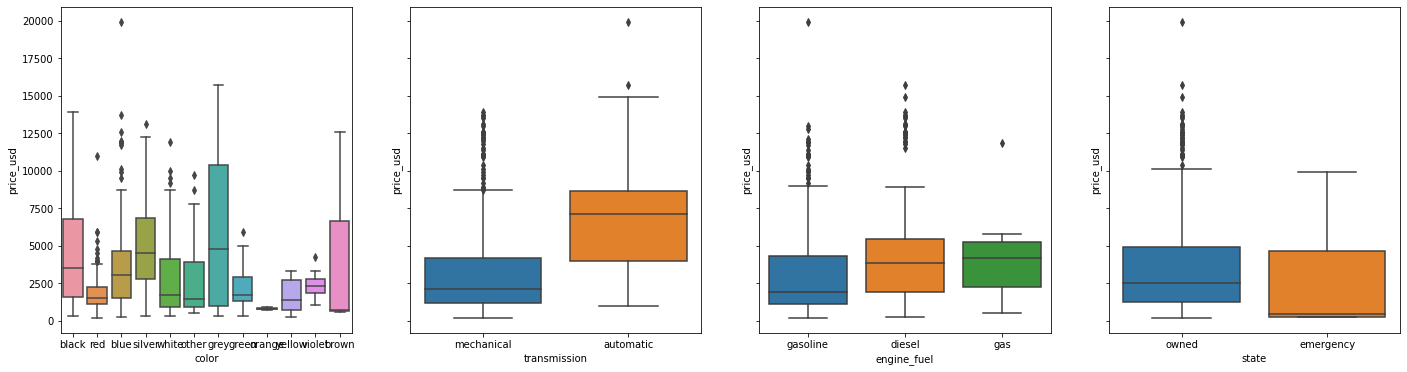

In [46]:
## Pipeline, count number of elements, loop creation
## Show counts?
vwjetta_df = SelectModel('/home/gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf')
fig, axs = plt.subplots(ncols=4, figsize=(24,6),sharey=True)
sns.boxplot(x='color',y='price_usd',data=vwjetta_df, ax=axs[0])
sns.boxplot(x='transmission',y='price_usd',data=vwjetta_df, ax=axs[1])
sns.boxplot(x='engine_fuel',y='price_usd',data=vwjetta_df, ax=axs[2])
sns.boxplot(x='state',y='price_usd',data=vwjetta_df, ax=axs[3])

In [18]:
def Dummies(df,column):
    return pd.concat([df, pd.get_dummies(df[column])],axis=1).drop(column,axis=1)

In [129]:
Dummies(SelectModel('/home/gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf'),['transmission','state','engine_fuel','drivetrain','color'])

,odometer_value,year_produced,engine_capacity,price_usd,transmission_automatic,transmission_mechanical,state_emergency,state_owned,engine_fuel_diesel,engine_fuel_gas,...,color_brown,color_green,color_grey,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow
0,213000,2001,1.8,6300.00,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,260000,1999,1.9,3400.00,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,280000,1996,1.9,2100.00,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,290000,1994,1.6,1480.00,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,267000,2000,1.9,4000.00,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,200000,2009,1.4,7000.00,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
703,291500,1994,1.9,1500.00,0,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
704,240000,1983,1.1,350.00,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
705,400000,1990,1.6,711.37,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
vwjetta_df.corr()

,odometer_value,year_produced,engine_capacity,price_usd,diesel,gas,gasoline,hybrid-petrol,trans_auto,state_emergency
odometer_value,1.000000,-0.532571,0.158329,-0.579777,0.247802,0.080907,-0.245307,-0.053788,-0.324705,-0.055061
year_produced,-0.532571,1.000000,0.022668,0.931963,-0.096546,-0.042625,0.087846,0.063223,0.509471,-0.107848
engine_capacity,0.158329,0.022668,1.000000,-0.113834,0.146251,0.072640,-0.134292,-0.101728,0.104730,-0.065017
price_usd,-0.579777,0.931963,-0.113834,1.000000,-0.099243,-0.037504,0.075028,0.112198,0.460052,-0.133286
diesel,0.247802,-0.096546,0.146251,-0.099243,1.000000,-0.067144,-0.895870,-0.051787,-0.180846,0.051989
gas,0.080907,-0.042625,0.072640,-0.037504,-0.067144,1.000000,-0.287556,-0.016622,0.030709,-0.025611
gasoline,-0.245307,0.087846,-0.134292,0.075028,-0.895870,-0.287556,1.000000,-0.221786,0.133349,-0.034016
hybrid-petrol,-0.053788,0.063223,-0.101728,0.112198,-0.051787,-0.016622,-0.221786,1.000000,0.089339,-0.019753
trans_auto,-0.324705,0.509471,0.104730,0.460052,-0.180846,0.030709,0.133349,0.089339,1.000000,-0.061051
state_emergency,-0.055061,-0.107848,-0.065017,-0.133286,0.051989,-0.025611,-0.034016,-0.019753,-0.061051,1.000000


In [72]:
fruits = ["apple", "banana", "cherry"]
for x in fruits:
  print(x)

def CoefPearson(dataframe,col1,col2):
    coef, p = stats.pearsonr(dataframe[col1], dataframe[col2])
    return print("For",col1,"x",col2,"Pearson Coef:",coef,"P-Value:",p)

#Make loop
CoefPearson(vwjetta_df,"year_produced",'price_usd')
CoefPearson(vwjetta_df,"odometer_value",'price_usd')
CoefPearson(vwjetta_df,'engine_capacity','price_usd')
CoefPearson(vwjetta_df,'gas','price_usd')
CoefPearson(vwjetta_df,'gasoline','price_usd')
CoefPearson(vwjetta_df,'diesel','price_usd')
CoefPearson(vwjetta_df,'hybrid-petrol','price_usd')
CoefPearson(vwjetta_df,'trans_auto','price_usd')
CoefPearson(vwjetta_df,'state_emergency','price_usd')

apple
banana
cherry


In [136]:
col = list(vwjetta_df)
col

['odometer_value',
 'year_produced',
 'engine_capacity',
 'price_usd',
 'transmission_automatic',
 'transmission_mechanical',
 'state_emergency',
 'state_owned',
 'engine_fuel_diesel',
 'engine_fuel_gas',
 'engine_fuel_gasoline',
 'drivetrain_all',
 'drivetrain_front',
 'drivetrain_rear',
 'color_black',
 'color_blue',
 'color_brown',
 'color_green',
 'color_grey',
 'color_orange',
 'color_other',
 'color_red',
 'color_silver',
 'color_violet',
 'color_white',
 'color_yellow']

In [146]:
#Vamos Analisar a significância estatística das variáveis em comparação com o preço (price_usd).
#Neste projeto, vamos utilizar p < 0.05 como estatisticamente significante, ou seja, temos confiança de >95% de que a correlação entre os dados é significante, e não uma coincidência)
#create loop, all columns minus price usd tuple
vwjetta_df = Dummies(SelectModel('/home/gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv','Golf'),['transmission','state','engine_fuel','drivetrain','color'])
def CoefPearson(df):
    col = list(df)
    for x in col:
        coef, p = stats.pearsonr(df[x], df['price_usd'])
        return print("For",x,"x Price Pearson Coef:",coef,"P-Value:",p)

In [151]:
coef, p = stats.pearsonr(vwjetta_df["odometer_value"], vwjetta_df['price_usd'])
print("For odometer_value x Price Pearson Coef:",coef,"P-Value:",p)

For odometer_value x Price Pearson Coef: -0.3609646459343294 P-Value: 3.505528260091966e-23


In [147]:
CoefPearson(vwjetta_df)

For odometer_value x Price Pearson Coef: -0.3609646459343294 P-Value: 3.505528260091966e-23


In [ ]:
CoefPearson(vwjetta_df,"year_produced")
CoefPearson(vwjetta_df,"odometer_value")
CoefPearson(vwjetta_df,'engine_capacity')
CoefPearson(vwjetta_df,'gas')
CoefPearson(vwjetta_df,'gasoline')
CoefPearson(vwjetta_df,'diesel')
CoefPearson(vwjetta_df,'hybrid-petrol')
CoefPearson(vwjetta_df,'trans_auto')
CoefPearson(vwjetta_df,'state_emergency')

In [109]:
#vwjetta_df.drop(['gas','diesel','hybrid-petrol','engine_capacity'],axis=1,inplace=True)

In [110]:
#grp_year_produced=vwjetta_df[['year_produced', 'price_usd']].groupby(['year_produced'])
#grp_year_produced.head()

In [111]:
#Teste de ANOVA (Analise de Variância)
#O teste de ANOVA testa a significância da variação das médias entre grupos de uma mesma variável.
#Dois parâmetros são observados no teste ANOVA: Teste_F e Valor_P.
#Teste_F: ANOVA assume que a hipótese que a média entre os grupos é a mesma, e quantifica o desvio da média calculada pela média assumida. Quanto maior o Teste_F, maior a diferença entre médias.
#Valor_P: Indica o quão estatisticamente significante é o valor de Teste_F.

def Anova(dataframe,col1,col2):
    f_val, p_val = stats.f_oneway(dataframe[col1],dataframe[col2])
    return print( "ANOVA",col1,"x",col2, ": F=", f_val, ", P =", p_val)

#Make loop
Anova(vwjetta_df,"year_produced","price_usd")
Anova(vwjetta_df,"odometer_value","price_usd")
Anova(vwjetta_df,"trans_auto","price_usd")
Anova(vwjetta_df,"state_emergency","price_usd")

ANOVA year_produced x price_usd : F= 96.10590881029496 , P = 8.936854034287284e-21
ANOVA odometer_value x price_usd : F= 566.7698984595692 , P = 7.035245096650256e-83
ANOVA trans_auto x price_usd : F= 271.60735016353726 , P = 1.566992019416432e-48
ANOVA state_emergency x price_usd : F= 271.6375433605779 , P = 1.551994252060017e-48


Ponto de Interceptação: -713072.6179725266
Inclinação: [359.06372585]
Equação do Modelo: Preço =  -713072.6179725266 + ( [359.06372585] * Ano Produzido)


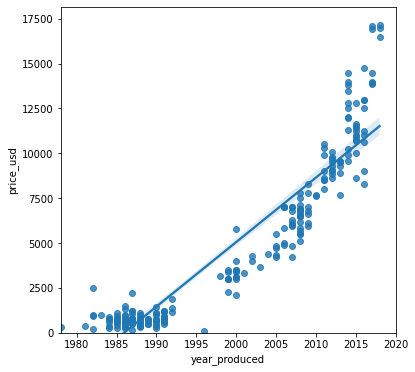

In [112]:
#Regressão Linear Simples
lm = LinearRegression()
X = vwjetta_df[['year_produced']]
Y = vwjetta_df['price_usd']
lm.fit(X,Y)
width = 6
height = 6
plt.figure(figsize=(width, height))
sns.regplot(x=X,y=Y,data=vwjetta_df)
plt.ylim(0,)
plt.xlim(vwjetta_df['year_produced'].min(),)
print("Ponto de Interceptação:",lm.intercept_)
print("Inclinação:",lm.coef_)
print('Equação do Modelo: Preço = ',lm.intercept_,'+ (',lm.coef_,'*','Ano Produzido)')

c:\Users\GFreitas\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


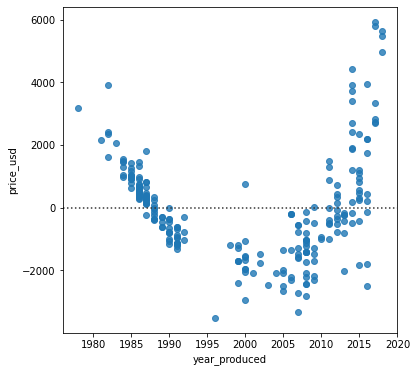

In [113]:
width = 6
height = 6
plt.figure(figsize=(width, height))
sns.residplot(vwjetta_df['year_produced'], vwjetta_df['price_usd'])
plt.show()

In [114]:
#Regressão Linear Múltipla
lm1 = LinearRegression()
Z = vwjetta_df[['odometer_value','year_produced', 'trans_auto','state_emergency']]
lm1.fit(Z,Y)
width = 6
height = 6
print("Ponto de Interceptação:",lm1.intercept_)
print("Coeficientes:",lm1.coef_)
print('Equação do Modelo: Preço = ',lm1.intercept_,'+ (',lm1.coef_[0],'*','Odômetro)+(',lm1.coef_[1],'*','Ano Produzido)+(',lm1.coef_[2],'*','Automático? 1-Sim, 0-Não)+(',lm1.coef_[3],'*','Acidentes? 1-Sim, 0-Não)')
print('VW Jetta com 120000 km rodados, ano de 2010, automático, sem acidentes, tem o preço predito :',(lm1.coef_[0]*120000)+(lm1.coef_[1]*2010)+(lm1.coef_[2]*1)+(lm1.coef_[3]*0)+lm1.intercept_)

Ponto de Interceptação: -667843.3003646503
Coeficientes: [-4.16319105e-03  3.36969409e+02 -2.94234442e+02 -1.29609687e+03]
Equação do Modelo: Preço =  -667843.3003646503 + ( -0.004163191051663159 * Odômetro)+( 336.96940898343144 * Ano Produzido)+( -294.2344420889819 * Automático? 1-Sim, 0-Não)+( -1296.0968682667103 * Acidentes? 1-Sim, 0-Não)
VW Jetta com 120000 km rodados, ano de 2010, automático, sem acidentes, tem o preço predito : 8671.394323758315


c:\Users\GFreitas\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\GFreitas\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


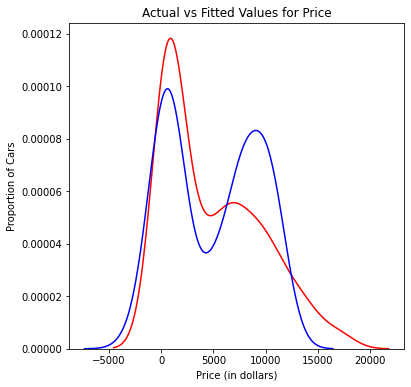

In [115]:
Y_hat = lm1.predict(Z)
plt.figure(figsize=(width, height))
ax1 = sns.distplot(vwjetta_df['price_usd'], hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

        3        2
0.2292 x - 1361 x + 2.692e+06 x - 1.775e+09


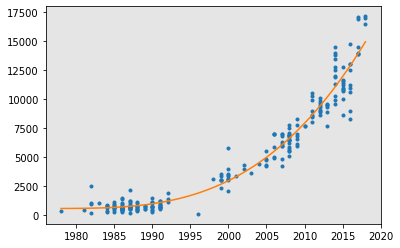

In [116]:
#Regressao Polinomial

x = vwjetta_df['year_produced']

def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(x.min(),x.max())
    y_new = model(x_new)
    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()

f = np.polyfit(x, Y, 3)
p = np.poly1d(f)
print(p)
PlotPolly(p, x, Y, 'year_produced')

In [117]:
J = 2010 #input do ano a ser predito
print((p[0])+(p[1]*(J))+(p[2]*(J**2))+(p[3]*(J**3)))

7918.641908407211


In [118]:
#Avaliar melhor modelo:
#RLS RSquared e MSE
print('RSquared é:',lm.score(X,Y))
Yhat=lm.predict(X)
mse1 = mean_squared_error(vwjetta_df['price_usd'], Yhat)
print('MSE é:', mse1)

RSquared é: 0.8685550890811768
MSE é: 2781382.8061697735


In [119]:
#RLM RSquared e MSE
print('RSquared é:',lm1.score(Z,Y))
Y_predict_multifit = lm1.predict(Z)
mse2 = mean_squared_error(vwjetta_df['price_usd'], Y_predict_multifit)
print('MSE é:', mse2)

RSquared é: 0.8810794123195461
MSE é: 2516367.3173949667


In [120]:
#PR RSquared e MSE
r_squared = r2_score(Y, p(x))
print('RSquared é:', r_squared)
mse3 = mean_squared_error(vwjetta_df['price_usd'], p(x))
print('MSE é:', mse3)

RSquared é: 0.9537088064282794
MSE é: 979524.6463134292


In [121]:
#Predições
Ano = 2010
Odometro = 120000
Automatico = 1
Acidente = 0
Auto = 'Automático' if Automatico==1 else 'Manual'
Ac = 'Acidentado' if Acidente==1 else 'Não Acidentado'
print('O preço predito por RLS com ano',Ano,'é:',(lm.coef_*Ano)+lm.intercept_)
print('O preço predito por RLM com',Odometro,'km rodados, ano',Ano,Auto,',',Ac,'é:',(lm1.coef_[0]*Odometro)+(lm1.coef_[1]*Ano)+(lm1.coef_[2]*Automatico)+(lm1.coef_[3]*Acidente)+lm1.intercept_)
print('O preço predito por RP de 3 graus com ano',Ano,'é:',(p[0])+(p[1]*(Ano))+(p[2]*(Ano**2))+(p[3]*(Ano**3)))

O preço predito por RLS com ano 2010 é: [8645.47098992]
O preço predito por RLM com 120000 km rodados, ano 2010 Automático , Não Acidentado é: 8671.394323758315
O preço predito por RP de 3 graus com ano 2010 é: 7918.641908407211
